In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [11]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])
data_X = np.log1p(data_X.astype(np.float32))
data_X = data_X / data_X.max()
data_X = 2.0 * data_X - 1.0 # Range [-1, 1]

# Define 1-Wire Circuit
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def pixel_circuit(inputs):
    # inputs: (Batch_Size,) -> List of scalars
    # Map [-1, 1] -> [0, pi]
    thetas = (inputs + 1.0) * (np.pi / 2.0)
    
    # Single Qubit Rotation
    qml.RY(thetas, wires=0)
    
    # Measure Z expectation
    return qml.expval(qml.PauliZ(0))

def embed_pixels_flat(images):
    """
    Process every pixel individually.
    images: (N, 64, 64)
    returns: (N, 1, 64, 64)
    """
    print("Flattening images...")
    N, H, W = images.shape
    # Flatten everything: (N * 64 * 64)
    flat_pixels = torch.tensor(images).view(-1)
    
    print(f"Embedding {len(flat_pixels)} pixels...")
    
    # Huge Batch Size (Since circuit is trivial 1-wire)
    batch_size = 16384 
    results = []
    
    with torch.no_grad():
        for i in range(0, len(flat_pixels), batch_size):
            batch = flat_pixels[i : i + batch_size]
            q_out = pixel_circuit(batch)
            results.append(q_out)
            
            if i % (batch_size * 50) == 0:
                print(f"Processed {i} pixels...")
            
    results = torch.cat(results, dim=0)
    
    # Reshape back to image
    # Note: Channels = 1
    q_images = results.reshape(N, 1, H, W)
    return q_images.float()

quantum_data = embed_pixels_flat(data_X)

print(f"Data Shape: {data_X.shape}") # (1000, 64, 64)

Using device: mps
Flattening images...
Embedding 4096000 pixels...
Processed 0 pixels...
Processed 819200 pixels...
Processed 1638400 pixels...
Processed 2457600 pixels...
Processed 3276800 pixels...
Data Shape: (1000, 64, 64)


In [12]:
# %%
class PixelDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable inverse function
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1) # Output 1 channel
        )
        
    def forward(self, x):
        return self.net(x)

decoder = PixelDecoder().to(device)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-3)
crit_dec = nn.MSELoss()

dset_dec = TensorDataset(quantum_data.to(device), torch.tensor(data_X).unsqueeze(1).to(device))
loader_dec = DataLoader(dset_dec, batch_size=64, shuffle=True)

print("Training Decoder...")
for epoch in range(10):
    total_loss = 0
    for q, real in loader_dec:
        pred = decoder(q)
        loss = crit_dec(pred, real)
        opt_dec.zero_grad()
        loss.backward()
        opt_dec.step()
        total_loss += loss.item()
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: {total_loss/len(loader_dec):.6f}")

decoder.eval()

Training Decoder...
Epoch 0: 1.260783
Epoch 2: 0.861784
Epoch 4: 0.406412
Epoch 6: 0.085606
Epoch 8: 0.002527


PixelDecoder(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [13]:
# %%
# Reuse TimeEmbedding from previous cells or re-paste it
# Assuming TimeEmbedding is defined

class CoordUNet(nn.Module):
    def __init__(self, in_ch=1): # Changed to 1 channel
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 1 quantum + 2 coord = 3
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

# Training Loop
def robust_weighted_loss(pred, target, x1_data, weight_factor=10.0):
    # x1_data is now 1 channel. Signal is ~ -1. Background ~ +1.
    importance = (1.0 - x1_data) * 0.5
    weights = 1.0 + (weight_factor * importance)
    return ((pred - target)**2 * weights).mean()

model = CoordUNet(in_ch=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(TensorDataset(quantum_data.to(device)), batch_size=32, shuffle=True)

print("Training Pixel-Wise Flow Matching...")
losses = []
for epoch in range(1, 41):
    model.train()
    batch_loss = 0
    for (x1,) in loader:
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)
        t_view = t.view(-1, 1, 1, 1)
        x_t = (1-t_view)*x0 + t_view*x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        loss = robust_weighted_loss(pred_v, target_v, x1)
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        batch_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {batch_loss/len(loader):.5f}")
        losses.append(batch_loss/len(loader))

Training Pixel-Wise Flow Matching...
Epoch 10: Loss 0.17658
Epoch 20: Loss 0.08057
Epoch 30: Loss 0.06705
Epoch 40: Loss 0.05721


In [6]:
# %%
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        return self.lin(torch.cat([torch.sin(args), torch.cos(args)], dim=-1))

class CoordUNet(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 4 quantum + 2 coord = 6
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        # Add Coordinates
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

Training Naive Flow Matching...
Epoch 10: Loss 0.29124
Epoch 20: Loss 0.20439
Epoch 30: Loss 0.16579
Epoch 40: Loss 0.15553
Epoch 50: Loss 0.15007


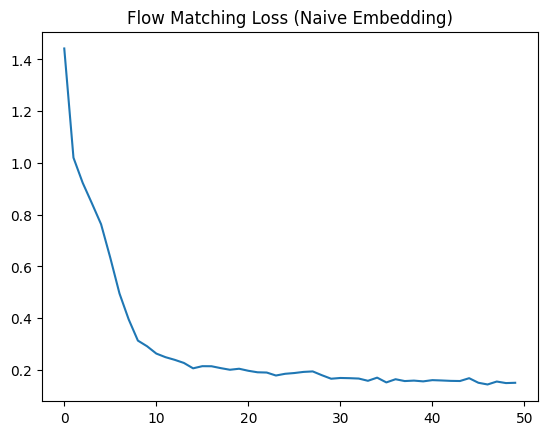

In [7]:
def robust_weighted_loss(pred, target, x1_data, weight_factor=10.0):
    # x1_data (Real Quantum Data):
    # Background (-1 pixel) -> 0 angle -> +1 Expectation
    # Signal (+1 pixel)     -> pi angle -> -1 Expectation
    
    # We want to weight the Signal (-1).
    # Importance = (1.0 - x1) / 2.0  => Backg(1)->0, Signal(-1)->1
    importance = (1.0 - x1_data) * 0.5
    weights = 1.0 + (weight_factor * importance)
    
    diff = (pred - target) ** 2
    return (diff * weights).mean()

model = CoordUNet(in_ch=4).to(device)
opt_flow = optim.Adam(model.parameters(), lr=1e-4)
dset_flow = TensorDataset(quantum_data.to(device))
loader_flow = DataLoader(dset_flow, batch_size=32, shuffle=True)

print("Training Naive Flow Matching...")
losses = []

for epoch in range(1, 51):
    model.train()
    batch_loss = 0.0
    for (x1,) in loader_flow:
        x1 = x1.to(device)
        B = x1.shape[0]
        x0 = torch.randn_like(x1)
        t = torch.rand(B, device=device)
        
        t_view = t.view(B, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        
        # Weighted Loss
        loss = robust_weighted_loss(pred_v, target_v, x1_data=x1)
        
        opt_flow.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt_flow.step()
        batch_loss += loss.item()
        
    avg = batch_loss / len(loader_flow)
    losses.append(avg)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {avg:.5f}")

plt.plot(losses)
plt.title("Flow Matching Loss (Naive Embedding)")
plt.show()

In [14]:
class CoordUNet(nn.Module):
    def __init__(self, in_ch=1): # Changed to 1 channel
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 1 quantum + 2 coord = 3
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

# Training Loop
def robust_weighted_loss(pred, target, x1_data, weight_factor=10.0):
    # x1_data is now 1 channel. Signal is ~ -1. Background ~ +1.
    importance = (1.0 - x1_data) * 0.5
    weights = 1.0 + (weight_factor * importance)
    return ((pred - target)**2 * weights).mean()

model = CoordUNet(in_ch=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(TensorDataset(quantum_data.to(device)), batch_size=32, shuffle=True)

print("Training Pixel-Wise Flow Matching...")
losses = []
for epoch in range(1, 41):
    model.train()
    batch_loss = 0
    for (x1,) in loader:
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)
        t_view = t.view(-1, 1, 1, 1)
        x_t = (1-t_view)*x0 + t_view*x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        loss = robust_weighted_loss(pred_v, target_v, x1)
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        batch_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {batch_loss/len(loader):.5f}")
        losses.append(batch_loss/len(loader))

Training Pixel-Wise Flow Matching...
Epoch 10: Loss 0.22395
Epoch 20: Loss 0.19206
Epoch 30: Loss 0.17488
Epoch 40: Loss 0.14755
